# Loading data

In [1]:
import torch
import pandas as pd
import numpy as np
import BRG
from BRG import CustomGraphDataset

In [2]:
import os
os.chdir(r'/data/coding/Buchwald')

#文件读取顺序必须对应特征节点
files = ['Aryl_halide_new.csv', 'Product_new.csv', 'Base_new.csv', 'Ligand_new.csv', 'Additive_new.csv']
features = BRG.load_and_preprocess_data(files)
labels = pd.read_csv('Buchwald.csv').iloc[:, -1].values/100

# GNN Model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch_geometric.nn import GATConv
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.loader import DataLoader
import random

In [4]:
class Net(nn.Module):
    def __init__(self, in_channels):
        super(Net, self).__init__()
        self.conv1 = GATConv(in_channels, 512, heads=2)  # 确保in_channels已定义
        self.norm1 = nn.BatchNorm1d(1024)
        self.conv2 = GATConv(1024, 256, heads=2)
        self.norm2 = nn.BatchNorm1d(512)

        self.lin1 = nn.Linear(3072, 1024)
        self.lin2 = nn.Linear(1024, 512)
        self.lin3 = nn.Linear(512, 256)
        self.lin4 = nn.Linear(256, 128)
        self.lin5 = nn.Linear(128, 1)
        self.bn1 = nn.BatchNorm1d(3072)
        self.bn2 = nn.BatchNorm1d(1024)
        self.bn3 = nn.BatchNorm1d(512)
        self.bn4 = nn.BatchNorm1d(256)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # 处理卷积层返回的元组
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x1 = F.relu(x)

        x = self.conv2(x1, edge_index)
        x = self.norm2(x)
        x2 = F.relu(x)

        x = torch.cat([x1, x2], 1)

        x_mean = gap(x, batch=batch)
        x_max = gmp(x, batch=batch)
        x = torch.cat([x_mean, x_max], 1)

        x = x.view(x.shape[0], -1)

        x = self.bn1(x)
        x = self.lin1(x)
        x = nn.Dropout(p=0.5)(x)
        x = nn.ReLU()(x)

        x = self.bn2(x)
        x = self.lin2(x)
        x = nn.ReLU()(x)

        x = self.bn3(x)
        x = self.lin3(x)
        x = nn.ReLU()(x)

        x = self.bn4(x)
        x = self.lin4(x)
        x = nn.ReLU()(x)

        x = self.lin5(x)

        return x.squeeze()

# Different topology types

In [5]:
edge_index_dict = {
    'Chain': torch.tensor([[0,0,1,1,2,2,3,3,4,4,1,3,2],
                           [0,2,1,4,2,3,3,1,4,1,3,2,0]], dtype=torch.long),
    'Cycle': torch.tensor([[0,0,0,1,1,2,2,3,3,4,4,4,1,3,2],
                           [0,2,4,1,4,2,3,3,1,4,1,0,3,2,0]], dtype=torch.long),
    'Tree': torch.tensor([[0,0,1,1,2,2,3,3,4,4,4,4,4],
                          [0,4,1,4,2,4,3,4,0,1,2,3,4]], dtype=torch.long),
    'Star': torch.tensor([[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,4],
                          [0,1,2,4,1,0,3,4,2,0,3,4,3,1,2,4,4,0,1,2,3]], dtype=torch.long),
    'Complete': torch.tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,4],
                              [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3,4]], dtype=torch.long)              
}

# visualization

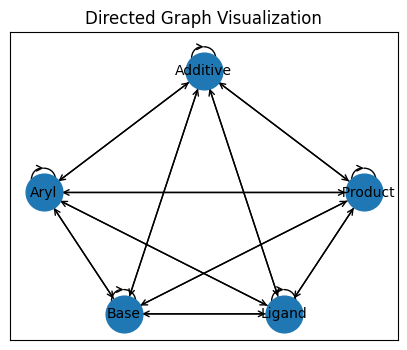

In [13]:
from BRG import visualize_graph_data
from torch_geometric.data import Data
data = Data(edge_index =edge_index_dict['Complete'])
visualize_graph_data(data,5, {0: (0, 1),1: (2, 1),2: (0.5, 0),3: (1.5, 0),4: (1, 2)}, 
node_labels = {0: 'Aryl',1: '  Product',2: 'Base',3: 'Ligand',4: 'Additive'})

# Model Training

In [ ]:
import numpy as np
import csv
import torch
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
# 忽略特定的警告
warnings.filterwarnings("ignore")

for edge_type, edge_index in edge_index_dict.items():
    # 生成dataset
    datas = BRG.create_all_graphs(features, edge_index)
    dataset = CustomGraphDataset(datas, labels)

    # 定义损失函数，对于回归任务通常使用均方误差损失(MSEL)
    criterion = torch.nn.MSELoss()

    # 初始化模型
    model = Net(100).to(device)

    # 选择优化器，这里使用Adam，你可以根据需要调整学习率等参数
    opti = torch.optim.Adam(model.parameters(), lr=1e-4)

    # 设定随机种子，以确保随机数生成的可复现性
    random.seed(42)  # Python的random模块种子
    torch.manual_seed(42)  # PyTorch的随机种子

    # 将数据集分割为训练集和验证集，这里以70%训练，30%验证为例
    train_size = int(0.7 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    # 创建DataLoader用于批量训练
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=512)
    print(f'成功生成{edge_type}训练数据！')

    # CSV文件路径
    metrics_csv_path = f'/data/coding/{edge_type}_metrics.csv'

    # 定义CSV的列名
    fieldnames = ['Epoch', 'Train_Loss', 'Val_Loss', 'Train_RMSE', 'Val_RMSE', 'Train_R2', 'Val_R2', 'Train_MAE', 'Val_MAE']

    num_epochs = 2000
    train_losses = []  # 用于存储每轮的训练损失
    test_losses = []  # 新增：用于存储每轮的测试损失
    maes_train = []  # 用于存储每轮训练集的MAE
    rmses_train = []  # 用于存储每轮训练集的RMSE
    r2s_train = []  # 用于存储每轮训练集的R²
    maes_test = []  # 新增：用于存储每轮测试集的MAE
    rmses_test = []  # 新增：用于存储每轮测试集的RMSE
    r2s_test = []  # 新增：用于存储每轮测试集的R²

    # 初始化CSV文件
    with open(metrics_csv_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    print(f'当前正在使用{edge_type}训练模型：')
    # 训练阶段
    for epoch in tqdm(range(num_epochs), desc=f"Epochs for {edge_type} Model"):
        model.train()
        running_loss_train = 0.0
        all_preds_train = []
        all_targets_train = []

        for data in train_loader:
            out = model(data[0].to(device))  # 通过模型得到预测结果
            loss = criterion(out, data[1].to(device))  # 计算损失
            opti.zero_grad()
            loss.backward()
            opti.step()
            running_loss_train += loss.item()  # 累加损失

            # 保存预测值和目标值用于计算RMSE和R²
            all_preds_train.append(out.detach().cpu().numpy())
            all_targets_train.append(data[1].detach().cpu().numpy())

        epoch_loss_train = running_loss_train / len(train_loader)  # 平均损失

        # 将预测和目标列表转换为numpy数组进行计算
        all_preds_train = np.concatenate(all_preds_train)
        all_targets_train = np.concatenate(all_targets_train)

        # 计算训练集上的性能指标
        mae_train = mean_absolute_error(all_targets_train, all_preds_train)
        rmse_train = np.sqrt(np.mean((all_preds_train - all_targets_train) ** 2))
        r2_train = r2_score(all_targets_train, all_preds_train)

        # 测试阶段
        model.eval()
        with torch.no_grad():
            running_loss_val = 0.0
            all_preds_val = []
            all_targets_val = []

            for data in val_loader:
                # 预测与损失累加
                out = model(data[0].to(device))
                val_loss = criterion(out, data[1].to(device))
                running_loss_val += val_loss.item()

                # 收集预测与目标值
                all_preds_val.append(out.detach().cpu().numpy())
                all_targets_val.append(data[1].detach().cpu().numpy())

            epoch_loss_val = running_loss_val / len(val_loader)  # 平均测试损失
            test_losses.append(epoch_loss_val)

            # 将预测和目标列表转换为numpy数组进行计算
            all_preds_val = np.concatenate(all_preds_val)
            all_targets_val = np.concatenate(all_targets_val)

            # 计算测试集上的性能指标
            mae_val = mean_absolute_error(all_targets_val, all_preds_val)
            rmse_val = np.sqrt(np.mean((all_preds_val - all_targets_val) ** 2))
            r2_val = r2_score(all_targets_val, all_preds_val)

            # 记录本轮的指标
            train_losses.append(epoch_loss_train)
            maes_train.append(mae_train)
            rmses_train.append(rmse_train)
            r2s_train.append(r2_train)
            maes_test.append(mae_val)
            rmses_test.append(rmse_val)
            r2s_test.append(r2_val)

        # 写入CSV文件
        with open(metrics_csv_path, 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow({
                'Epoch': epoch + 1,
                'Train_Loss': epoch_loss_train,
                'Val_Loss': epoch_loss_val,
                'Train_RMSE': rmse_train,
                'Val_RMSE': rmse_val,
                'Train_R2': r2_train,
                'Val_R2': r2_val,
                'Train_MAE': mae_train,
                'Val_MAE': mae_val
            })

    print(f'{edge_type}模型训练完成！')
    print('***********************************************************************')

Creating graphs: 100%|██████████| 3955/3955 [00:01<00:00, 2942.91it/s]


成功生成Chain训练数据！
当前正在使用Chain训练模型：


Epochs for Chain Model: 100%|██████████| 2000/2000 [38:22<00:00,  1.15s/it]


Chain模型训练完成！
***********************************************************************


Creating graphs: 100%|██████████| 3955/3955 [00:01<00:00, 3355.10it/s]


成功生成Cycle训练数据！
当前正在使用Cycle训练模型：


Epochs for Cycle Model: 100%|██████████| 2000/2000 [38:29<00:00,  1.15s/it]


Cycle模型训练完成！
***********************************************************************


Creating graphs: 100%|██████████| 3955/3955 [00:01<00:00, 3502.84it/s]


成功生成Tree训练数据！
当前正在使用Tree训练模型：


Epochs for Tree Model: 100%|██████████| 2000/2000 [38:24<00:00,  1.15s/it]


Tree模型训练完成！
***********************************************************************


Creating graphs: 100%|██████████| 3955/3955 [00:01<00:00, 3606.31it/s]


成功生成Star训练数据！
当前正在使用Star训练模型：


Epochs for Star Model: 100%|██████████| 2000/2000 [39:06<00:00,  1.17s/it]


Star模型训练完成！
***********************************************************************


Creating graphs: 100%|██████████| 3955/3955 [00:01<00:00, 3579.52it/s]


成功生成Complete训练数据！
当前正在使用Complete训练模型：


Epochs for Complete Model:  42%|████▏     | 840/2000 [16:09<22:43,  1.18s/it]

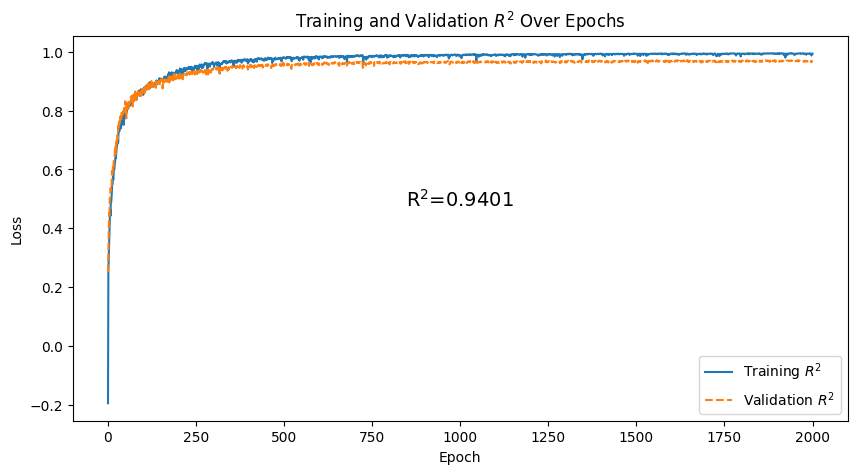

In [8]:
# 训练完成后，绘制训练和验证损失曲线
plot_save_path = '/data/coding/Buchwald/training_and_validation_r2_plot.png'
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), r2s_train, label='Training $R^2$')
plt.plot(range(1, num_epochs + 1), r2s_test, label='Validation $R^2$', linestyle='--')
plt.text(1000, 0.5, 'R$^2$=0.9401', fontsize=14, va='center', ha='center')
plt.title('Training and Validation $R^2$ Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig(plot_save_path)  # 保存图表到当前目录
plt.show()  # 显示图表

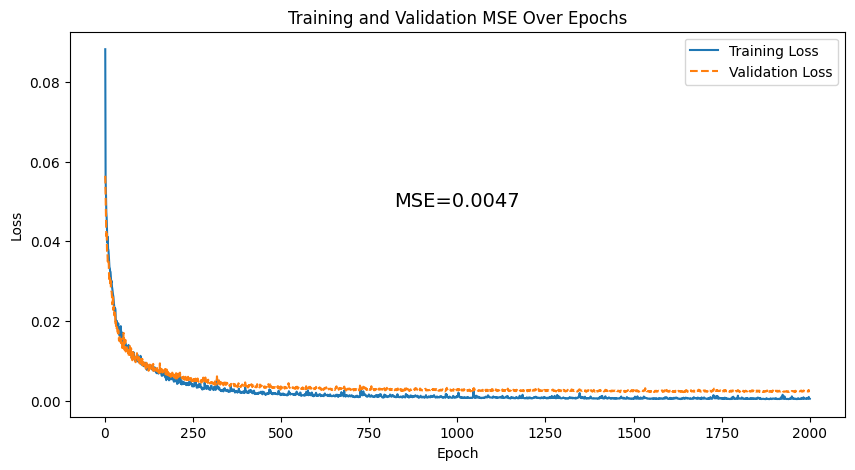

In [9]:
# 训练完成后，绘制训练和验证损失曲线
plot_save_path = '/data/coding/Buchwald/training_and_validation_loss_plot.png'
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Validation Loss', linestyle='--')
plt.text(1000, 0.05, 'MSE=0.0047', fontsize=14, va='center', ha='center')
plt.title('Training and Validation MSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig(plot_save_path)  # 保存图表到当前目录
plt.show()  # 显示图表